# Reinforcement Learning: Pendulum
## Temporal-Difference Methods: Q-Learning

This notebook will explore the implementation of a Temporal-Difference (TD) method, Q-Learning, on the Pendulum environment.

## 1. Imports and Utilities




In [1]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [2]:
# Import necessary libraries and modules
import sys
import gym
import numpy as np
import random
import glob
import os
import io
import base64
from collections import namedtuple
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from pyvirtualdisplay import Display

# Create a virtual display for rendering environments without a physical display
display = Display(visible=0, size=(1400, 900))
display.start()

# Define a named tuple to store episode statistics
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

In [3]:
# Import the necessary module for mounting Google Drive
from google.colab import drive

# Mount your Google Drive to '/content/drive' in the Colab environment
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path for video storing
path = "/content/drive/MyDrive/RL/train2/pendulum/"
video_dir = os.path.join(path,"videos/")

# Ensuring the directories exist or creating them
os.makedirs(video_dir, exist_ok=True)

### Utility Functions




#### Plot Values

In [5]:
# Function to plot the Episode statistics
# Adapted from: https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

def plot_episode_stats(stats, smoothing_window=10, noshow=False):

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig2, fig3

In [6]:
# Plot State Values
def plot_values(V, shape):
    # Reshape the value function V to the given shape
    V = np.reshape(V, shape)

    # Create a new figure with a specific size
    fig = plt.figure(figsize=(15,5))

    # Add a subplot to the figure. 111 means 1x1 grid, first subplot.
    ax = fig.add_subplot(111)

    # Display the reshaped value function V as an image on the axes
    im = ax.imshow(V, cmap='cool')

    # For each value in V, annotate the plot with the value's rounded label
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)

    # Disable ticks and tick labels for both x and y axes
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

    # Set the title for the plot
    plt.title('State-Value Function')

    # Display the plot
    plt.show()


#### Simulate and show video

In [7]:
def simulate_and_show_video(env, policy):
    """
    Simulate an environment using a given policy and display the video.

    Parameters:
    - env: The Pendulum environment.
    - policy: The 3D policy to use for taking actions.

    Returns:
    - HTML object if video was captured, or a message indicating no videos were found.
    """

    # Create a video recorder for the environment, saving the video as 'video.mp4'
    video_path = '/content/drive/MyDrive/RL/train2/pendulum/videos/video.mp4'
    recorder = VideoRecorder(env, path=video_path)

    # Reset the environment to its initial state
    state = env.reset()
    done = False

    while not done:
        # Map the continuous state to the discretized policy indices
        state_discretized = map_continuous_state_to_discrete(state)

        # Select an action based on the current state and the given policy
        action = policy[state_discretized]

        # Take a step in the environment using the selected action
        state, _, done, _ = env.step(action_space[action])

        # Capture the current frame for the video
        frame = env.render("rgb_array")
        recorder.capture_frame()

    # Close the video recorder
    recorder.close()

    # Close the environment
    env.close()

    # Display the video in the notebook
    video = open(video_path, "rb").read()
    encoded_video = base64.b64encode(video).decode("ascii")
    video_html = f'<video alt="test" autoplay loop controls style="height: 400px;"><source src="data:video/mp4;base64,{encoded_video}" type="video/mp4" /></video>'
    return HTML(video_html)

def map_continuous_state_to_discrete(state):
    """
    Convert the continuous state to a discrete state based on the policy shape.

    Parameters:
    - state: The continuous state to be discretized.

    Returns:
    - discrete_state: The discrete state based on policy shape.
    """
    # Convert the continuous state to a discrete state based on the policy shape
    discrete_state = get_discrete_state(state)

    # Ensure that the discrete state falls within the bounds of the policy_shape
    discrete_state = tuple(max(0, min(s, ps - 1)) for s, ps in zip(discrete_state, discrete_os_size))

    return discrete_state


## 2. Q-learning Algorithms



### 2.1 Helper function:

#### Epsilon Greedy Action Selection

In [8]:
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Select an action based on an epsilon-greedy policy.

    Parameters:
    - Q: A Q-table containing Q-values for state-action pairs.
    - state: The current state for which an action needs to be selected.
    - epsilon: The exploration-exploitation trade-off factor (0 <= epsilon <= 1).

    Returns:
    - selected_action: The action to be taken, either randomly with a probability of epsilon or greedily with (1 - epsilon).
    """

    # Generate a random number between 0 and 1. If it's less than epsilon,
    # then choose a random action, else the greedy action (the action with the maximum Q-value for the current state)
    if random.uniform(0, 1) < epsilon:
        return random.choice(list(action_space.values()))[0]
    else:
        action_index = np.argmax(Q[state])
        return list(action_space.values())[action_index][0]


#### Policy Extraction from Optimal-Q Values

In [9]:
def extract_policy_V_from_Q(Q):
    """
    Extract policy and state-value function V from Q.

    Params:
    - Q: Action-value function (Q-table).

    Returns:
    - policy: Derived policy from Q.
    - V: Derived state-value function from Q.
    """

    num_states = Q.shape[:-1]
    num_actions = Q.shape[-1]

    policy = np.argmax(Q, axis=-1)
    V = np.max(Q, axis=-1)

    return policy, V

### 2.2 Q-Learning Algorithm



#### Pseudo-code for Q-Learning (off-policy TD control) from Sutton and Barto's book:




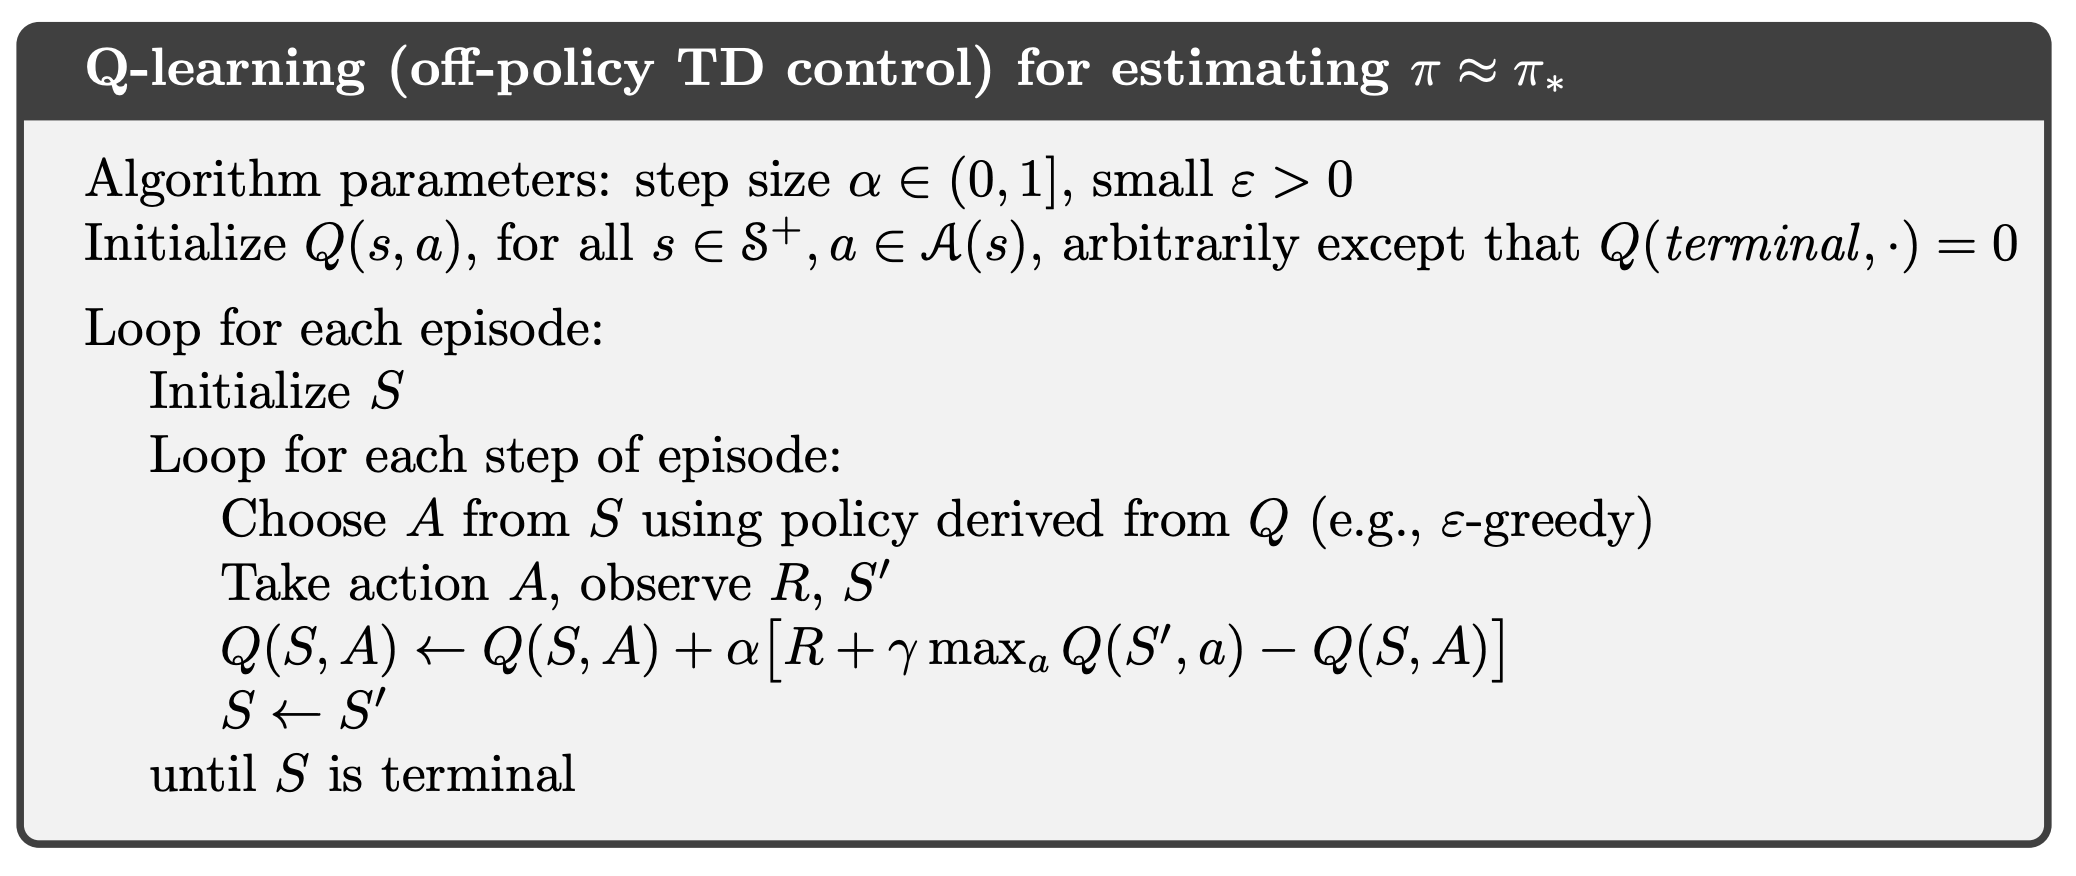

## Q-Learning Algorithm Code

### Discretization of action and observations space

In [10]:
# Discretization code adapted from https://github.com/BhanuPrakashPebbeti/Q-Learning_and_Double-Q-Learning/tree/main

# Create the 'Pendulum-v1' environment
env = gym.make('Pendulum-v1')

# Making discrete action space
discrete_action_space_size = 33
discrete_action_space_win_size = (env.action_space.high - env.action_space.low) / (discrete_action_space_size - 1)
action_space = {}

# Populate the action space with discrete actions
for i in range(discrete_action_space_size):
    action_space[i] = [env.action_space.low[0] + (i * discrete_action_space_win_size[0])]

# Making discrete observation space
discrete_os_size = [21, 21, 81]
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / [i-1 for i in discrete_os_size]

def get_discrete_state(state):
    """
    Convert a continuous state to a discrete state.

    Parameters:
    - state: The continuous state to be discretized.

    Returns:
    - discrete_state: The discrete state.
    """
    ds = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(ds.astype(np.int32))

# To get action index
def action_idx(desired_value):
    """
    Get the index of an action in the discrete action space based on its desired value.

    Parameters:
    - desired_value: The desired action value to find the index for.

    Returns:
    - action_index: The index of the action in the discrete action space.
    """
    for key, value in action_space.items():
        if value[0] == desired_value:
            return key


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [11]:
def q_learning(env, num_episodes, gamma=0.99, alpha=0.85, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.

    Returns:
        Q is the optimal action-value function,
        stats is a named tuple, which returns the episode statistics for plotting.
    """

    # Initialize Q values/Table to Zero
    Q = np.zeros(discrete_os_size + [discrete_action_space_size], dtype=float)

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Initialize variables for max, min, and total rewards
    max_reward = -np.inf
    min_reward = np.inf
    total_reward = 0
    last_1000_rewards = []  # Store the rewards for the last 1000 episodes

    # Run through several episodes
    for episode in range(num_episodes):
        # Store cumulative reward of each episode in r
        r = 0

        # Initialize the state
        state = get_discrete_state(env.reset())

        # Reset the episode's time step, will be used for stats
        timeStep = 0

        while True:
            # Select the action using epsilon-greedy policy
            action = epsilon_greedy_policy(Q, state, epsilon)

            # Perform the action and move to the next state, and receive the reward
            nextstate, reward, done, info = env.step(action_space[action_idx(action)])

            # Update statistics
            stats.episode_rewards[episode] += reward
            timeStep += 1
            stats.episode_lengths[episode] = timeStep

            # Calculate the Q-value of the previous state using the update rule
            nextstate_idx = get_discrete_state(nextstate)
            best_next_action_idx = np.argmax(Q[nextstate_idx])

            TD_target = reward + gamma * Q[nextstate_idx][best_next_action_idx]
            TD_error = TD_target - Q[state][action_idx(action)]

            Q[state][action_idx(action)] += alpha * TD_error

            # Update the state with the next state
            state = nextstate_idx

            # Store the rewards
            r += reward

            # Break the loop if it is the terminal state of the episode
            if done:
                break

        # Update max, min, and total rewards for this episode
        max_reward = max(max_reward, r)
        min_reward = min(min_reward, r)
        total_reward += r

        # Add the reward to the last 1000 rewards list
        last_1000_rewards.append(r)

        # If we have more than 1000 rewards, remove the oldest one
        if len(last_1000_rewards) > 1000:
            total_reward -= last_1000_rewards[0]
            last_1000_rewards.pop(0)

    # Calculate average reward over the last 1000 episodes
    mean_rewards = np.mean(last_1000_rewards)

    print("Max Reward : ", max_reward)
    print("Min Reward : ", min_reward)
    print("Total Reward for Last 1000 Episodes: ", total_reward)
    print("Mean Reward for Last 1000 Episodes: ", mean_rewards)

    return Q, stats


## 3. Running the Q-Learning Algorithms on Pendulum environments and Plotting Results



## Pendulum Environment Exploration

In [12]:
# Create an instance of the 'CliffWalking-v0' environment.
# 'CliffWalking' is a standard gridworld environment where the agent has to navigate from a start state to a goal state,
# avoiding falling off a cliff.
env = gym.make('Pendulum-v1')

# Print the action space of the environment.
# This will show the number of possible actions an agent can take in the environment.
print(env.action_space)

# Print the observation space of the environment.
# This will show the number of possible states (or observations) an agent can encounter in the environment.
print(env.observation_space)

Box(-2.0, 2.0, (1,), float32)
Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


### Train the agent using Q-Learning

In [13]:
# Train agent using the Q-Learning algorithm
Q_table, stats = q_learning(env, 12000, gamma=0.99, alpha=0.5, epsilon=0.1)

Max Reward :  -0.23163251526113787
Min Reward :  -1855.2372197947448
Total Reward for Last 1000 Episodes:  -897689.6254421799
Mean Reward for Last 1000 Episodes:  -897.6896254421736


### Extract policy and plot the value function

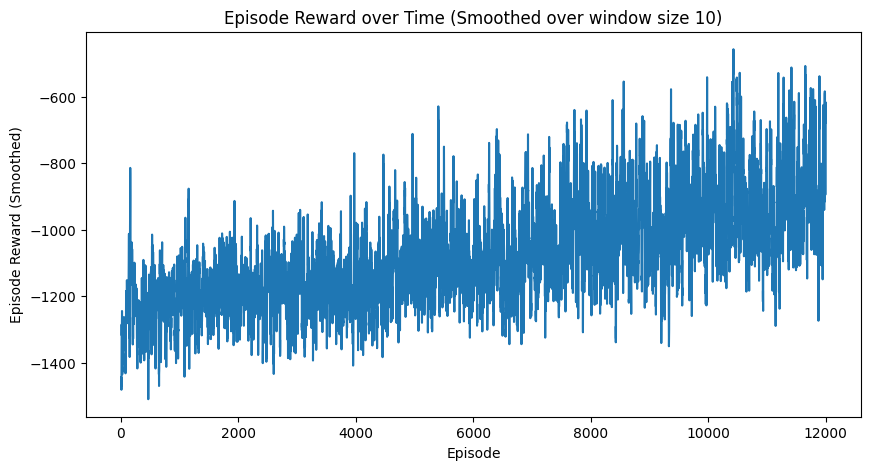

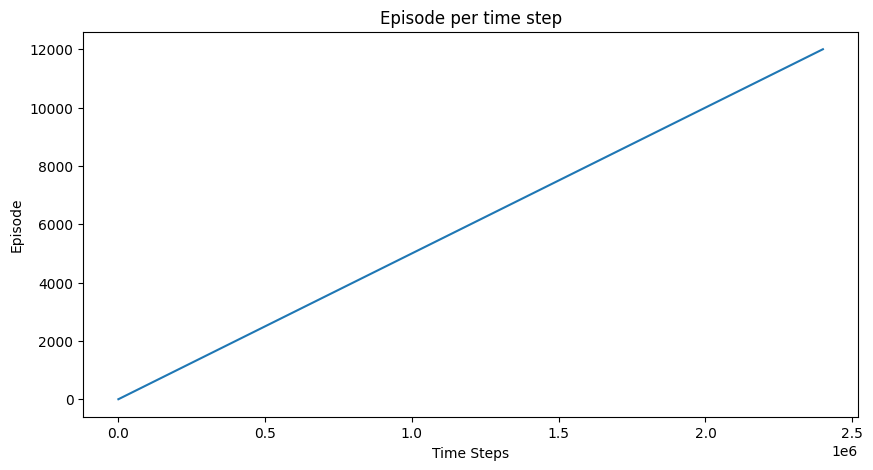

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

In [14]:
# The Episode Statistics
plot_episode_stats(stats)

In [15]:
# Extract the optimal policy and corresponding state-value function (V)
policy_QL, V_QL = extract_policy_V_from_Q(Q_table)

### Simulating the Optimal Policy

To visualize how the agent performs using the optimal policy derived from the Q-Learning algorithm, we'll simulate the environment and generate a video.

In [16]:
# Simulate the environment using the optimal policy suggested by Q-Learning and display the video
simulate_and_show_video(env, policy_QL)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Pendulum-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
S